[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sebastienmorichon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sebastienmorichon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sebastienmorichon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/var/folders/hy/g05wz4ln30z1r5z3mv1rwd2h0000gn/T/ipykernel_69553/1868103389.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the

Accuracy: 0.9111111111111111
Classification Report:
                             precision    recall  f1-score   support

                 Baby Care       0.93      0.72      0.81        57
  Beauty and Personal Care       0.91      0.89      0.90        44
                 Computers       0.96      1.00      0.98        43
Home Decor & Festive Needs       0.85      0.93      0.89        42
           Home Furnishing       0.79      0.98      0.87        42
          Kitchen & Dining       0.97      0.93      0.95        42
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.91       315
                 macro avg       0.92      0.92      0.91       315
              weighted avg       0.92      0.91      0.91       315



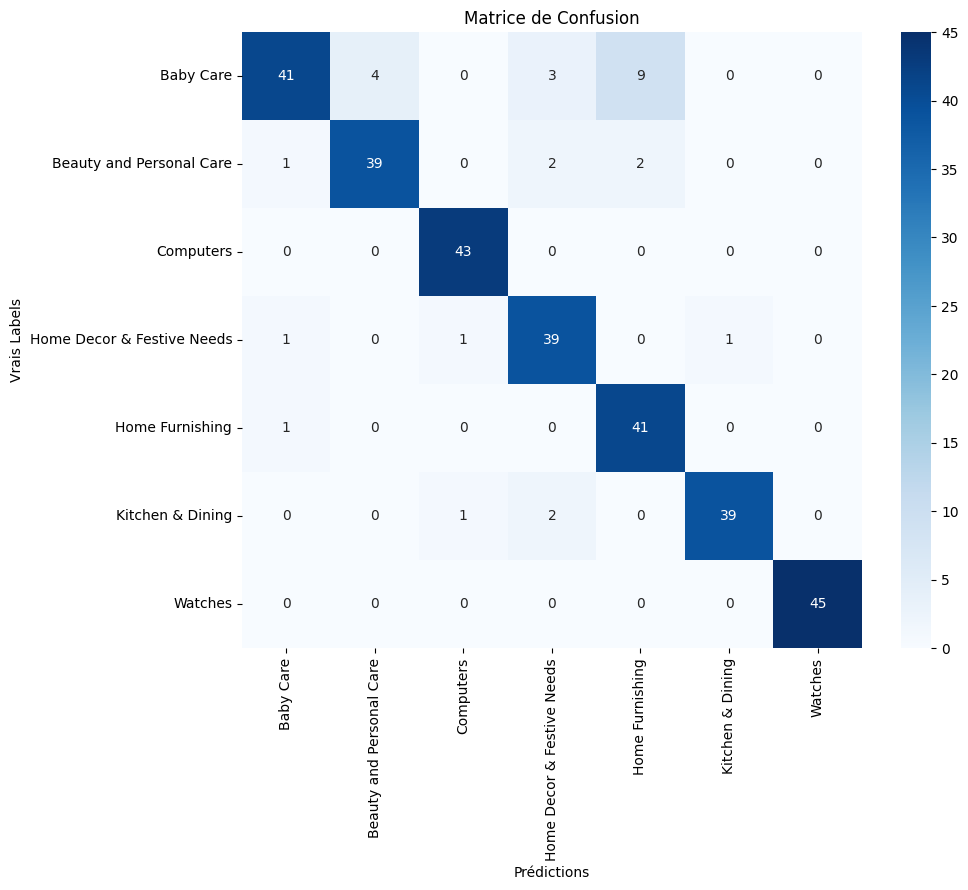

Scores de validation croisée: [0.89115646 0.9047619  0.93197279 0.93877551 0.91156463]
Score moyen de validation croisée: 0.9156462585034013


/opt/anaconda3/envs/DS_PROJET_8/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/DS_PROJET_8/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


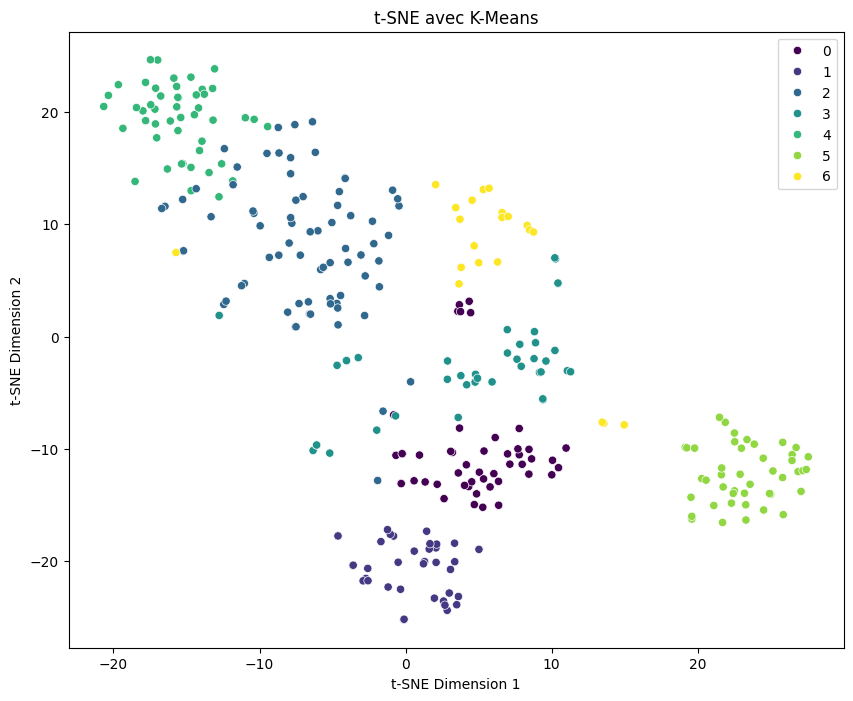

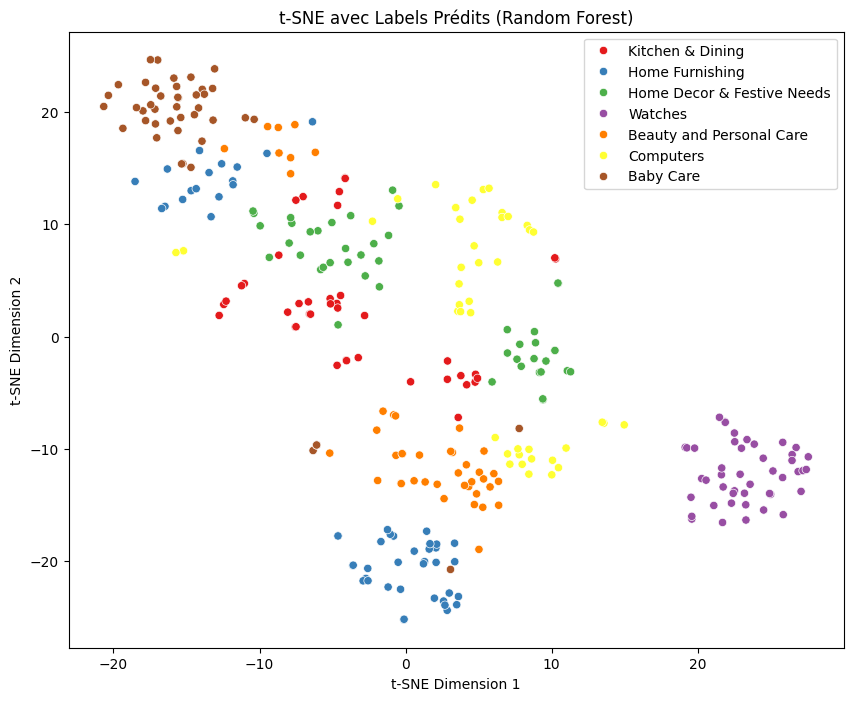

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024/12/24 18:19:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle enregistré avec MLFlow.


In [11]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import mlflow
import mlflow.sklearn
import seaborn as sns
import matplotlib.pyplot as plt

# Initialisation des ressources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Chargement des données
data = pd.read_csv('Base de données/flipkart_com-ecommerce_sample_1050.csv')
data = data[["uniq_id", "product_name", "description", "product_category_tree"]]

# Nettoyage et extraction des catégories
data["product_category_tree"].replace(to_replace=r'[\["\]]', value="", regex=True, inplace=True)
category = data["product_category_tree"].str.split(" >> ", expand=True)
category.rename(columns={0: "Categorie"}, inplace=True)
data = data.join(category["Categorie"])

# Fonction de nettoyage de texte
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.strip()

data['cleaned_description'] = data['description'].apply(clean_text)

# Tokenisation, suppression des stopwords et lemmatisation
def preprocess_text(column):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    def process(text):
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    return column.apply(process)

data['processed_description'] = preprocess_text(data['cleaned_description'])

# Séparation des données
X = data['processed_description']
y = data['Categorie']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Modèle SBERT
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Génération des embeddings
X_train_embeddings = sbert_model.encode(X_train.tolist(), convert_to_tensor=False)
X_test_embeddings = sbert_model.encode(X_test.tolist(), convert_to_tensor=False)

# Fine-tuning SBERT (Optionnel)
def fine_tune_sbert():
    train_examples = [InputExample(texts=[desc1, desc2], label=1.0)
                      for desc1, desc2 in zip(X_train[:50], X_train[50:100])]
    
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
    train_loss = losses.CosineSimilarityLoss(model=sbert_model)

    sbert_model.fit(train_objectives=[(train_dataloader, train_loss)],
                    epochs=1,
                    warmup_steps=100)

# fine_tune_sbert()  # Décommenter si besoin de fine-tuning

# Modèle supervisé : RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0, n_estimators=100)

# Enregistrement des expériences dans MLFlow
mlflow.set_experiment("SBERT_Product_Classification")

with mlflow.start_run():
    # Entraînement du modèle
    rf_model.fit(X_train_embeddings, y_train)

    # Prédictions
    y_pred = rf_model.predict(X_test_embeddings)

    # Évaluation
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_mat = confusion_matrix(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)

    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
    plt.title("Matrice de Confusion")
    plt.xlabel("Prédictions")
    plt.ylabel("Vrais Labels")
    plt.savefig("confusion_matrix.png")
    plt.show()

    # Vérification de la surapprentissage avec la validation croisée
    from sklearn.model_selection import cross_val_score
    cross_val_scores = cross_val_score(rf_model, X_train_embeddings, y_train, cv=5)
    print("Scores de validation croisée:", cross_val_scores)
    print("Score moyen de validation croisée:", np.mean(cross_val_scores))
    
    # Visualisation avec t-SNE pour K-Means
    kmeans = KMeans(n_clusters=len(set(y_train)), random_state=0)
    kmeans_labels = kmeans.fit_predict(X_test_embeddings)

    tsne = TSNE(n_components=2, random_state=0)
    X_test_tsne = tsne.fit_transform(X_test_embeddings)

    # Visualisation des clusters K-Means
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], hue=kmeans_labels, palette='viridis', legend='full')
    plt.title("t-SNE avec K-Means")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.savefig("tsne_kmeans.png")
    plt.show()

    # Visualisation avec t-SNE pour les prédictions Random Forest
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], hue=y_pred, palette='Set1', legend='full')
    plt.title("t-SNE avec Labels Prédits (Random Forest)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.savefig("tsne_predictions.png")
    plt.show()

    # Enregistrement dans MLFlow
    mlflow.log_param("Model", "RandomForest")
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("Cross_Val_Score_Mean", np.mean(cross_val_scores))
    mlflow.sklearn.log_model(rf_model, "random_forest_model")

    # Sauvegarde des embeddings, rapports et visualisations dans MLFlow
    mlflow.log_text(report, "classification_report.txt")
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.log_artifact("tsne_kmeans.png")
    mlflow.log_artifact("tsne_predictions.png")

print("Modèle enregistré avec MLFlow.")
